### 

In [1]:
# make env
# pip install requests
# %pip install pandas
# %pip install matplotlib 
# %pip install -U scikit-learn

In [2]:
# Imports
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from IPython.display import display, HTML

### Load Dataset

In [3]:
# Dataset Source: https://www.kaggle.com/datasets/andrewsundberg/college-basketball-dataset?select=cbb13.csv

dataframes = {}
directory = 'march_mad_data'

# Load general cbb.csv dataset into a dataframe
for filename in os.listdir(directory):
    if filename.endswith("cbb.csv"):
        path = os.path.join(directory, filename)
        dataframes[filename] = pd.read_csv(path)

In [4]:
df = dataframes["cbb.csv"]
print(df)

                TEAM  CONF   G   W  ADJOE  ADJDE  BARTHAG  EFG_O  EFG_D   TOR  \
0     North Carolina   ACC  40  33  123.3   94.9   0.9531   52.6   48.1  15.4   
1          Wisconsin   B10  40  36  129.1   93.6   0.9758   54.8   47.7  12.4   
2           Michigan   B10  40  33  114.4   90.4   0.9375   53.9   47.7  14.0   
3         Texas Tech   B12  38  31  115.2   85.2   0.9696   53.5   43.0  17.7   
4            Gonzaga   WCC  39  37  117.8   86.3   0.9728   56.6   41.1  16.2   
...              ...   ...  ..  ..    ...    ...      ...    ...    ...   ...   
3518          Toledo   MAC  34  27  119.9  109.6   0.7369   56.3   52.9  13.6   
3519         Liberty  ASun  33  27  111.4   97.3   0.8246   55.5   49.3  16.0   
3520     Utah Valley   WAC  34  28  107.1   94.6   0.8065   51.7   44.0  19.3   
3521             UAB  CUSA  38  29  112.4   97.0   0.8453   50.3   47.3  17.3   
3522     North Texas  CUSA  36  31  110.0   93.8   0.8622   51.2   44.5  19.8   

      ...  FTRD  2P_O  2P_D

### Data Cleaning

In [5]:
clean_df = df.replace("N/A", "NA")
print(df["SEED"].unique())
print(f"number of rows: {len(clean_df)}")
print(f"number of columns: {len(clean_df.columns)}")

[ 1.  3.  8.  4.  2.  7.  6.  9. 11. 10.  5. nan 16. 12. 13. 14. 15.]
number of rows: 3523
number of columns: 24


# Drop columns we don't want


### Exploratory Data Analysis (EDA)

In [12]:
placement_df = clean_df.dropna()

# Define a dictionary to map the postseason labels to numbers
postseason_mapping = {'Champions': 1, '2ND': 2, 'F4': 4, 'E8': 8, 'R16': 16, 'R32': 32, 'R64': 64}

# Use the map() function to convert the values in the "POSTSEASON" column
df['POSTSEASON'] = df['POSTSEASON'].map(postseason_mapping)

print(placement_df["POSTSEASON"].unique())
print(len(placement_df))

['2ND' 'Champions' 'E8' 'F4' 'R32' 'R64' 'R68' 'S16']
680


In [8]:
placement_df = placement_df.drop(columns=['TEAM'])
one_hot_encoded = pd.get_dummies(placement_df['CONF'])
placement_df = placement_df.drop(columns=['CONF'])
placement_df = pd.concat([placement_df, one_hot_encoded], axis=1)
placement_df['WINRATE'] = placement_df['W'] / placement_df['G']

In [8]:
# Compare conference and whether the team qualifies for March Madness (EDA) !!!!!!!!!!!!!!!!!!!!!

In [9]:
correlation_table = placement_df.corr()['POSTSEASON']

# Sort the correlation table
sorted_correlation_table = correlation_table.sort_values(ascending=False)

# Display the sorted correlation table with scrollable output
display(HTML(sorted_correlation_table.to_frame().to_html()))
# print(correlation_table)

ValueError: could not convert string to float: '2ND'

### EDA Analysis

In [10]:
### Team attributes with the highest impact on seeding 
### (larger magnitude correlations from the correlation table)

# WAB = Wins Above Bubble (May not use because bubble/March Madness cutoff is always changing)
# BARTHAG = Power Ranking / Chance of beating an average D1 team (May not use because subjective power-ranking)
# ADJOE = Adjusted Offensive Efficiency (number of points scored every 100 possessions)
# W = Wins
# G = Games
# ORB = Offensive Rebound Rate
# EFG_O = Effective Field Goal Percentage Short
# 2P_O = 2 Point shooting percentage

# ADJDE = Adjusted Defensive Efficiency (number of points allowed every 100 opponent possessions)
# 2P_D = 2 Point shooting percentage allowed
# EFG_D = Effective Field Goal percentage allowed
# TOR = Turnover Rate
# FTR_D = Free Throw Rate allowed

# B12
# ACC
# B10

### Training Machine Learning Models

#### Create data splits

In [11]:
# Select the relevant columns for training the model
features = ['WINRATE', 'ADJOE', 'ADJDE', 'EFG_O', 'EFG_D', 'TOR', 'ORB', 'FTRD', '2P_D']

# Split the data into training and testing sets
X = placement_df[features]
y = placement_df['SEED']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

#### Decision Tree

In [12]:
# Create a decision tree classifier
dt_classifier = DecisionTreeClassifier()

# Train the classifier on the training data
dt_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_classifier.predict(X_test)

# Calculate the accuracy of the classifier
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.14705882352941177


In [13]:
# Get the predicted seed values
predicted_seeds = dt_classifier.predict(X_test)

# Get the actual seed values
actual_seeds = placement_df.loc[X_test.index]['SEED']

# Calculate the absolute difference between predicted and actual seeds
seed_diff = np.abs(predicted_seeds - actual_seeds)

# Calculate the average distance
average_distance = np.mean(seed_diff)

print("DT Average Distance between Predicted and Actual Seed:", average_distance)

DT Average Distance between Predicted and Actual Seed: 2.2205882352941178


#### Random Forest Classifier

In [14]:
# Train the Random Forest model
rf_classifier = RandomForestClassifier(n_estimators=200, random_state=42)
rf_classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.36764705882352944


In [15]:
# Get the predicted seed values
predicted_seeds = rf_classifier.predict(X_test)

# Get the actual seed values
actual_seeds = placement_df.loc[X_test.index]['SEED']

# Calculate the absolute difference between predicted and actual seeds
seed_diff = np.abs(predicted_seeds - actual_seeds)

# Calculate the average distance
average_distance = np.mean(seed_diff)

print("RF Average Distance between Predicted and Actual Seed:", average_distance)

RF Average Distance between Predicted and Actual Seed: 1.4705882352941178


### Grid Search RF

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Create the random forest classifier
rf = RandomForestClassifier()

# Create the grid search object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)

# Fit the grid search to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Use the best parameters to create the final random forest model
final_rf = RandomForestClassifier(**best_params)

# Fit the final model to the training data
final_rf.fit(X_train, y_train)

# Evaluate the final model on the test data
accuracy = final_rf.score(X_test, y_test)

print("Final Random Forest Model Accuracy:", accuracy)

In [27]:
print("Final Random Forest Model Accuracy:", accuracy)

Final Random Forest Model Accuracy: 0.3382352941176471


In [26]:
# Get the predicted seed values
predicted_seeds = final_rf.predict(X_test)

# Get the actual seed values
actual_seeds = placement_df.loc[X_test.index]['SEED']

# Calculate the absolute difference between predicted and actual seeds
seed_diff = np.abs(predicted_seeds - actual_seeds)

# Calculate the average distance
average_distance = np.mean(seed_diff)

print("RF Average Distance between Predicted and Actual Seed:", average_distance)

RF Average Distance between Predicted and Actual Seed: 1.4411764705882353


#### Neural Network

In [19]:
from sklearn.neural_network import MLPClassifier

# Create an instance of the MLPClassifier
model = MLPClassifier(hidden_layer_sizes=(50, 50, 50), activation='relu', solver='adam', random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test data
predictions = model.predict(X_test)

# Evaluate the accuracy of the model
accuracy = model.score(X_test, y_test)

# Print the predictions and accuracy
print("Predictions:", predictions)
print("Accuracy:", accuracy)

Predictions: [11. 16.  3. 16.  3. 16. 15. 11. 11.  4.  8.  3. 15. 16.  3. 11. 11.  4.
  8. 16.  2.  3. 11. 15. 15.  2.  8.  3. 11.  3. 11. 15. 11. 11.  2.  3.
  2.  3. 15.  2.  3. 15.  1. 11.  8. 16. 11. 16.  1. 15.  1. 15. 11. 11.
 14. 14. 11.  1.  3.  3. 11.  2.  8. 12. 11. 16. 13. 11.]
Accuracy: 0.27941176470588236


In [20]:
# Get the predicted seed values
predicted_seeds = model.predict(X_test)

# Get the actual seed values
actual_seeds = placement_df.loc[X_test.index]['SEED']

# Calculate the absolute difference between predicted and actual seeds
seed_diff = np.abs(predicted_seeds - actual_seeds)

# Calculate the average distance
average_distance = np.mean(seed_diff)

print("DT Average Distance between Predicted and Actual Seed:", average_distance)

DT Average Distance between Predicted and Actual Seed: 1.7352941176470589


In [23]:
# Print actual vs predicted seed to check how accurate the predictions are
# model = dt_classifier # Change to whatever model you want to use
model = rf_classifier 

predicted_seeds = model.predict(X_test)
for actual_seed, predicted_seed in zip(actual_seeds, predicted_seeds):
    print("Actual Seed:", actual_seed, ", Predicted Seed:", predicted_seed)

Actual Seed: 9.0 , Predicted Seed: 8.0
Actual Seed: 16.0 , Predicted Seed: 15.0
Actual Seed: 3.0 , Predicted Seed: 8.0
Actual Seed: 15.0 , Predicted Seed: 16.0
Actual Seed: 1.0 , Predicted Seed: 3.0
Actual Seed: 16.0 , Predicted Seed: 16.0
Actual Seed: 13.0 , Predicted Seed: 14.0
Actual Seed: 12.0 , Predicted Seed: 10.0
Actual Seed: 12.0 , Predicted Seed: 7.0
Actual Seed: 3.0 , Predicted Seed: 3.0
Actual Seed: 7.0 , Predicted Seed: 7.0
Actual Seed: 3.0 , Predicted Seed: 5.0
Actual Seed: 15.0 , Predicted Seed: 15.0
Actual Seed: 16.0 , Predicted Seed: 16.0
Actual Seed: 6.0 , Predicted Seed: 7.0
Actual Seed: 8.0 , Predicted Seed: 12.0
Actual Seed: 9.0 , Predicted Seed: 9.0
Actual Seed: 9.0 , Predicted Seed: 6.0
Actual Seed: 11.0 , Predicted Seed: 9.0
Actual Seed: 16.0 , Predicted Seed: 16.0
Actual Seed: 2.0 , Predicted Seed: 1.0
Actual Seed: 10.0 , Predicted Seed: 8.0
Actual Seed: 9.0 , Predicted Seed: 9.0
Actual Seed: 15.0 , Predicted Seed: 16.0
Actual Seed: 15.0 , Predicted Seed: 13.0
A

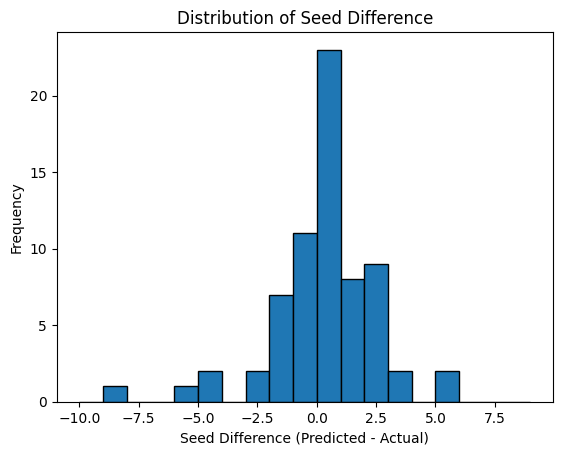

In [32]:
import matplotlib.pyplot as plt

# Calculate the difference between predicted seed and actual seed
seed_difference = predicted_seeds - actual_seeds

# Create a histogram of the seed difference
plt.hist(seed_difference, bins=range(-10, 10), edgecolor='black')

# Set the labels and title
plt.xlabel('Seed Difference (Predicted - Actual)')
plt.ylabel('Frequency')
plt.title('Distribution of Seed Difference')

# Show the plot
plt.show()

In [ ]:
# Predict whether a team will qualify for March Madness

In [ ]:
# Predict final post season result

In [ ]:
# Run on cbb24.csv